In [1]:
import os
import datetime
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/rl_sim/TACTILEDRIVEN_ARTO/UTILITIES')
from PreProcessingFunctions import myfilter, num_transient, sliding_sum_window, select_index, add_padding
from PreProcessingFunctions import WS, WS_B
from PreProcessingFunctions import rename_and_convert_to_txt

from Performance_plotter import plot_f1_score_threshold, plot_precision_recall_curve, plot_confusion_matrix, plot_roc_curve
from XAI_FCN import plot_grad_cam

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report

import tensorflow

gpus = tensorflow.config.list_physical_devices('GPU')
if gpus:    
    for gpu in gpus:
        tensorflow.config.set_logical_device_configuration(
            gpu,
            [tensorflow.config.LogicalDeviceConfiguration(memory_limit=4*1024)])  # Adjust memory limit as needed

from tensorflow.keras.models     import Sequential, Model, load_model
from tensorflow.keras.layers     import Input, Conv1D, Conv2D, BatchNormalization
from tensorflow.keras.layers     import Flatten, Dense, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D
from tensorflow.keras.layers     import LeakyReLU, ReLU, Activation, Dropout, Lambda
from tensorflow.keras.layers     import concatenate, Concatenate
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses     import BinaryCrossentropy
from tensorflow.keras.metrics    import AUC, Precision, Recall
from tensorflow.keras.callbacks  import EarlyStopping

from tensorflow.keras.utils      import plot_model

data_folder = '/home/rl_sim/thesis_ws/src/ML/DATA/1D_Fnew_GRIP_NotNorm/'

def load_data(data_folder):
    X_data = []
    y_data = []
    # Get list of all .npz files in the data folder
    npz_files = [file for file in os.listdir(data_folder) if file.endswith('.npz')]
    
    # Load data from each .npz file
    for file in npz_files:
        file_path = os.path.join(data_folder, file)
        data = np.load(file_path)
        X_data.append(data['X'])  # Assuming X_data is stored under 'X' key in the .npz file
        y_data.append(data['y'])  # Assuming y_data is stored under 'y' key in the .npz file
        data.close()
    
    # Convert lists to NumPy arrays
    X_data = np.array(X_data)
    y_data = np.array(y_data)
    
    return X_data, y_data

# Load the data
X_data, y_data = load_data(data_folder)

# Check the shape of loaded data
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)
#print("X_data.[0] shape: ", X_data[0].shape)

TEST_SIZE = 0.4
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"TOTAL DATA: {len(X_data)}  ||  Train = {100*(1-TEST_SIZE)}%  ||  Test = {100*TEST_SIZE}%")
print("Dimensions of X_train:", X_train.shape, "   ||  Dimensions of y_train:", y_train.shape)
print("Dimensions of X_test: ", X_test.shape, "   ||  Dimensions of y_test: ", y_test.shape)
print("Dimensions of X_val:  ", X_val.shape, "   ||  Dimensions of y_val:  ", y_val.shape)

2024-08-30 17:41:11.919055: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-30 17:41:11.944484: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-30 17:41:12.370994: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-08-30 17:41:12.669814: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more 

X_data shape: (0,)
y_data shape: (0,)


ValueError: With n_samples=0, test_size=0.4 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

# 1st COMBINED (96%)

/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-06-04 18:51:50.259398: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-04 18:51:50.259643: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-04 18:51:50.259776: I e

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 800, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 800, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 64)        │     42,464 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 32)        │     53,000 │ input_layer_2[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96)        │          0 │ sequential[0][0], │
│ (Concatenate)       │                   │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         97 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 95,561 (373.29 KB)

 Trainable params: 95,561 (373.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


I0000 00:00:1717519912.165132  120478 service.cc:145] XLA service 0x736eac005470 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717519912.165152  120478 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2024-06-04 18:51:52.217867: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-04 18:51:52.502431: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


19/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5158 - loss: 0.6905

I0000 00:00:1717519915.337665  120478 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 0.5357 - loss: 0.6850 - val_accuracy: 0.6655 - val_loss: 0.6097
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6800 - loss: 0.5959 - val_accuracy: 0.6655 - val_loss: 0.6162
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6941 - loss: 0.5557 - val_accuracy: 0.7167 - val_loss: 0.5632
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7182 - loss: 0.5331 - val_accuracy: 0.7270 - val_loss: 0.4743
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7916 - loss: 0.4432 - val_accuracy: 0.7986 - val_loss: 0.4212
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8173 - loss: 0.4079 - val_accuracy: 0.7747 - val_loss: 0.4211
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8217 - loss: 0.3774 - val_accuracy: 0.8020 - val_loss: 0.3763
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8671 - loss: 0.3140 - val_accuracy: 0.8259 - val_loss: 0.3195
E

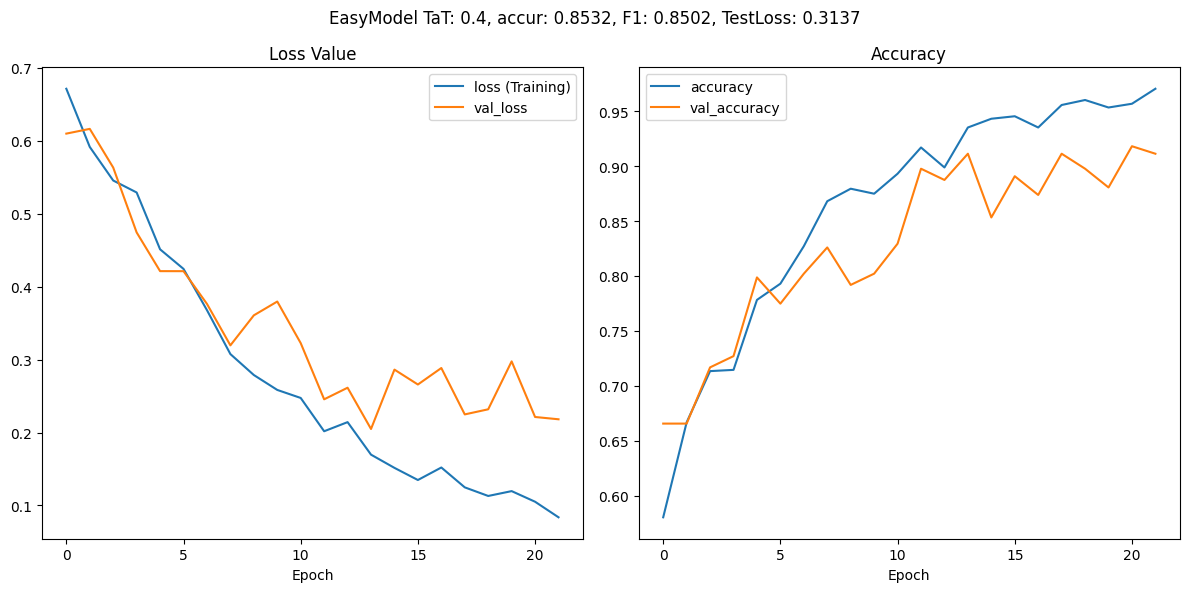

Train loss: 0.08380764722824097
Test val_loss: 0.21814526617527008
Train accuracy: 0.9704209566116333
Accuracy Score: 0.8532423208191127
F1 Score: 0.8501742160278746
Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.93      0.86       138
         1.0       0.92      0.79      0.85       155

    accuracy                           0.85       293
   macro avg       0.86      0.86      0.85       293
weighted avg       0.86      0.85      0.85       293



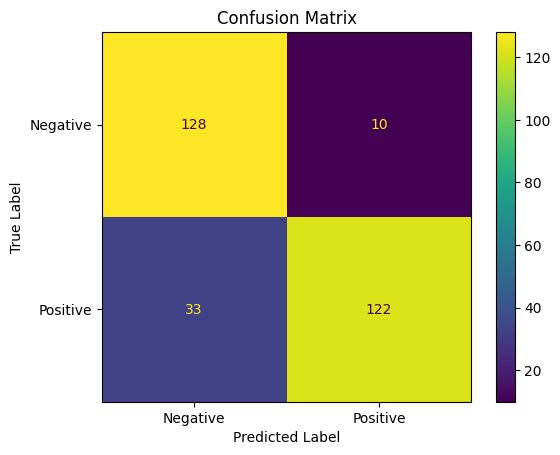

In [ ]:
def build_combined_model(input_shape):
    # First Model
    input1 = Input(shape=input_shape)
    model1 = Sequential()
    model1.add(Conv1D(filters=32, kernel_size=40, activation='relu', input_shape=input_shape))
    model1.add(MaxPooling1D(pool_size=4))
    model1.add(Conv1D(filters=64, kernel_size=10, activation='relu'))
    model1.add(MaxPooling1D(pool_size=2))
    model1.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
    model1.add(GlobalMaxPooling1D())
    #model1.add(Flatten())
    model1.add(Dense(64, activation='relu'))
    output1 = model1(input1)

    # Second Model
    input2 = Input(shape=input_shape)
    model2 = Sequential()
    model2.add(Conv1D(filters=32, kernel_size=20, activation='relu', input_shape=input_shape))
    model2.add(MaxPooling1D(pool_size=4))
    model2.add(Conv1D(filters=8, kernel_size=8, activation='relu'))
    model2.add(MaxPooling1D(pool_size=2))
    model2.add(Flatten())
    model2.add(Dense(64, activation='relu'))
    model2.add(Dropout(rate=0.1))
    model2.add(Dense(32, activation='relu'))
    
    output2 = model2(input2)

    merged = Concatenate()([output1, output2])
    merged = Dense(1, activation='sigmoid')(merged)
    combined_model = Model(inputs=[input1, input2], outputs=merged)

    return combined_model


model = build_combined_model((WS_B, 1))
model.summary()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit([X_train, X_train], [y_train, y_train], epochs=40, batch_size=32, validation_data=([X_val, X_val], [y_val, y_val]), verbose=1, callbacks=[early_stopping])

loss, accuracy = model.evaluate([X_test, X_test], [y_test, y_test])

# Predict labels for test data
y_pred = model.predict([X_test, X_test])
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)

# COMBINED 3 Branches

/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 800, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 800, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 800, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 64)        │     42,784 │ input_layer_4[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 32)        │     13,072 │ input_layer_6[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 32)        │     89,808 │ input_layer_8[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128)       │          0 │ sequential_2[0][… │
│ (Concatenate)       │                   │            │ sequential_3[0][… │
│                     │                   │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │        129 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 145,793 (569.50 KB)

 Trainable params: 145,793 (569.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 228ms/step - accuracy: 0.5678 - loss: 0.6791 - val_accuracy: 0.6826 - val_loss: 0.6236
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6361 - loss: 0.6250 - val_accuracy: 0.6928 - val_loss: 0.5742
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6695 - loss: 0.5961 - val_accuracy: 0.7235 - val_loss: 0.5243
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7465 - loss: 0.5277 - val_accuracy: 0.7304 - val_loss: 0.5035
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7443 - loss: 0.5120 - val_accuracy: 0.7201 - val_loss: 0.5032
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7482 - loss: 0.4645 - val_accuracy: 0.7645 - val_loss: 0.4331
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8247 - loss: 0.3958 - val_accuracy: 0.7713 - val_loss: 0.4252
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8230 - loss: 0.3714 - val_accuracy: 0.8259 - val_lo

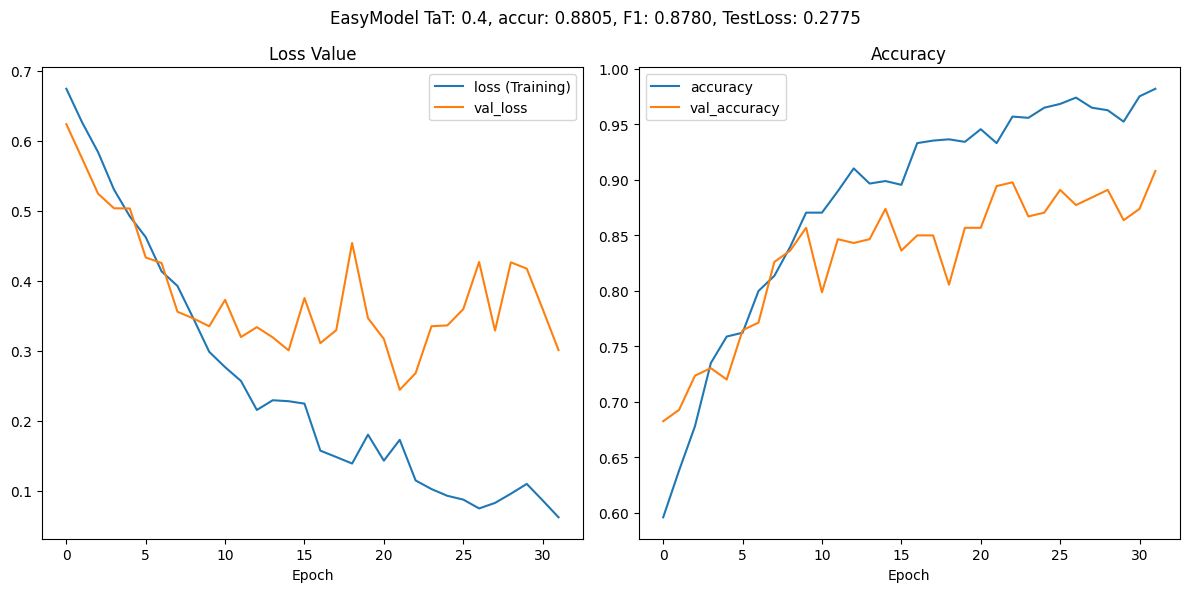

Train loss: 0.06188976392149925
Test val_loss: 0.30082544684410095
Train accuracy: 0.9817975163459778
Accuracy Score: 0.8805460750853242
F1 Score: 0.8780487804878049
Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.96      0.88       138
         1.0       0.95      0.81      0.88       155

    accuracy                           0.88       293
   macro avg       0.89      0.88      0.88       293
weighted avg       0.89      0.88      0.88       293



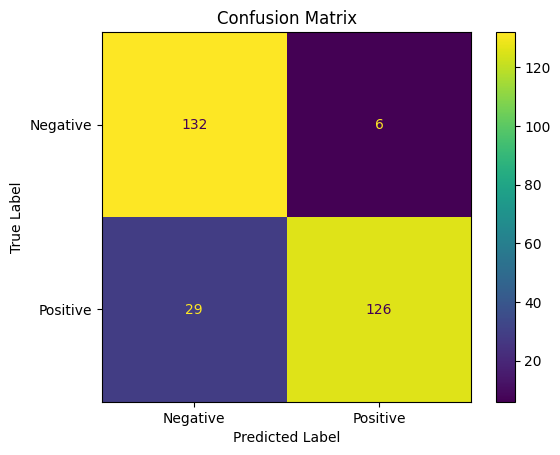

In [ ]:
def build_combined_model(input_shape):
    # First Model
    input1 = Input(shape=input_shape)
    model1 = Sequential()
    model1.add(Conv1D(filters=32, kernel_size=50, strides=10, activation='relu', input_shape=input_shape))
    model1.add(MaxPooling1D(pool_size=4))
    model1.add(Conv1D(filters=64, kernel_size=10, activation='relu'))
    model1.add(MaxPooling1D(pool_size=2))
    model1.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
    model1.add(GlobalMaxPooling1D())
    #model1.add(Flatten())
    model1.add(Dense(64, activation='relu'))
    output1 = model1(input1)

    # Second Model
    input2 = Input(shape=input_shape)
    model2 = Sequential()
    model2.add(Conv1D(filters=32, kernel_size=20, strides=10, activation='relu', input_shape=input_shape))
    model2.add(MaxPooling1D(pool_size=4))
    model2.add(Conv1D(filters=16, kernel_size=8, activation='relu'))
    model2.add(MaxPooling1D(pool_size=2))
    model2.add(Flatten())
    model2.add(Dense(64, activation='relu'))
    model2.add(Dropout(rate=0.2))
    model2.add(Dense(32, activation='relu'))
    
    output2 = model2(input2)

    # Third Model
    input3 = Input(shape=input_shape)
    model3 = Sequential()
    model3.add(Conv1D(filters=64, kernel_size=40, activation='relu', input_shape=input_shape))
    model3.add(MaxPooling1D(pool_size=4))
    model3.add(Conv1D(filters=32, kernel_size=20, activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Conv1D(filters=16, kernel_size=10, activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Flatten())
    model3.add(Dense(64, activation='relu'))
    model3.add(Dropout(rate=0.2))
    model3.add(Dense(32, activation='relu'))
    
    output3 = model3(input3)

    merged = Concatenate()([output1, output2, output3])
    merged = Dense(1, activation='sigmoid')(merged)
    combined_model = Model(inputs=[input1, input2, input3], outputs=merged)

    return combined_model


model = build_combined_model((WS_B, 1))
model.summary()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit([X_train, X_train, X_train], [y_train, y_train, y_train], epochs=50, batch_size=32, validation_data=([X_val, X_val, X_val], [y_val, y_val, y_val]), verbose=1, callbacks=[early_stopping])
loss, accuracy = model.evaluate([X_test, X_test, X_test], [y_test, y_test, y_test])

# Predict labels for test data
y_pred = model.predict([X_test, X_test, X_test])
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)


# BEST EASY BIG KERNEL + SMALL KERNEL

/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "functional_62"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 800, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_12      │ (None, 800, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 128)       │    331,456 │ input_layer_10[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 128)       │    164,480 │ input_layer_12[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 256)       │          0 │ sequential_5[0][… │
│ (Concatenate)       │                   │            │ sequential_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │     16,448 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │         65 │ dense_12[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 512,449 (1.95 MB)

 Trainable params: 512,449 (1.95 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40


2024-06-04 18:52:32.302499: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-04 18:52:32.756718: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-04 18:52:32.888806: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-04 18:52:33.658164: W external/local_tsl/tsl/framework/bfc

27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4971 - loss: 0.6952

2024-06-04 18:52:39.486802: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-04 18:52:39.794008: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-04 18:52:40.475220: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-04 18:52:40.512534: W external/local_tsl/tsl/framework/bfc

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.4986 - loss: 0.6949

2024-06-04 18:52:43.699061: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.20GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 299ms/step - accuracy: 0.5000 - loss: 0.6946 - val_accuracy: 0.6246 - val_loss: 0.6559
Epoch 2/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5842 - loss: 0.6538 - val_accuracy: 0.6758 - val_loss: 0.5748
Epoch 3/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6823 - loss: 0.5754 - val_accuracy: 0.6758 - val_loss: 0.5741
Epoch 4/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7162 - loss: 0.5326 - val_accuracy: 0.6177 - val_loss: 0.5588
Epoch 5/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7038 - loss: 0.5060 - val_accuracy: 0.7133 - val_loss: 0.4567
Epoch 6/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7648 - loss: 0.4679 - val_accuracy: 0.7474 - val_loss: 0.4334
Epoch 7/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7562 - loss: 0.4581 - val_accuracy: 0.7474 - val_loss: 0.4074
Epoch 8/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7661 - loss: 0.4069 - val_accuracy: 0.7952 - val_loss: 

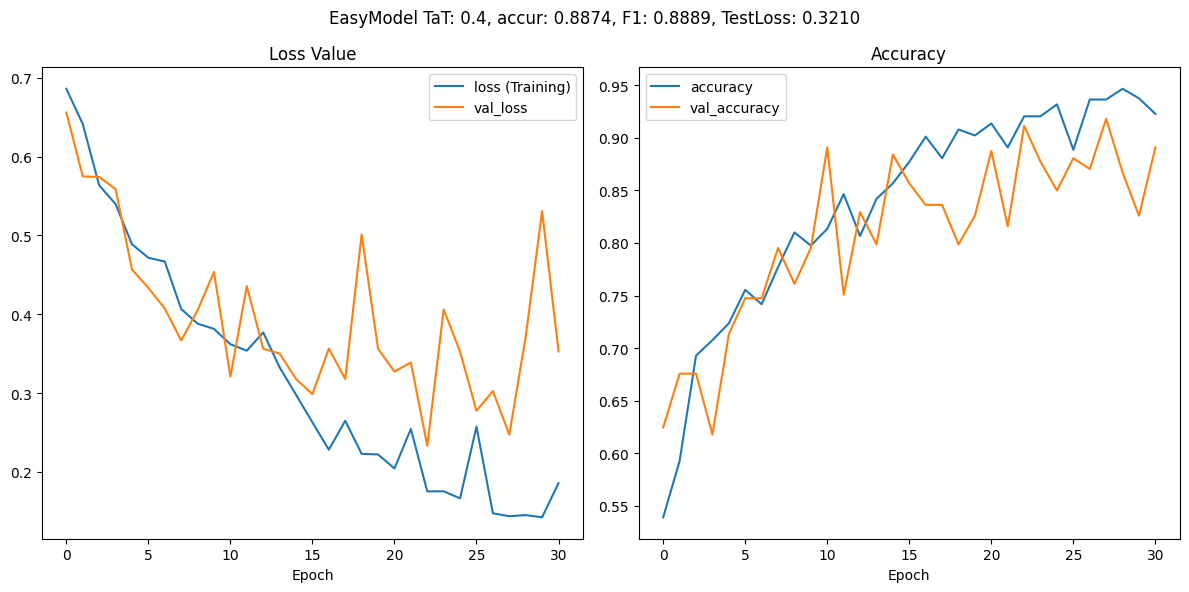

Train loss: 0.18580731749534607
Test val_loss: 0.35278013348579407
Train accuracy: 0.9226393699645996
Accuracy Score: 0.8873720136518771
F1 Score: 0.8888888888888888
Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.93      0.89       138
         1.0       0.93      0.85      0.89       155

    accuracy                           0.89       293
   macro avg       0.89      0.89      0.89       293
weighted avg       0.89      0.89      0.89       293



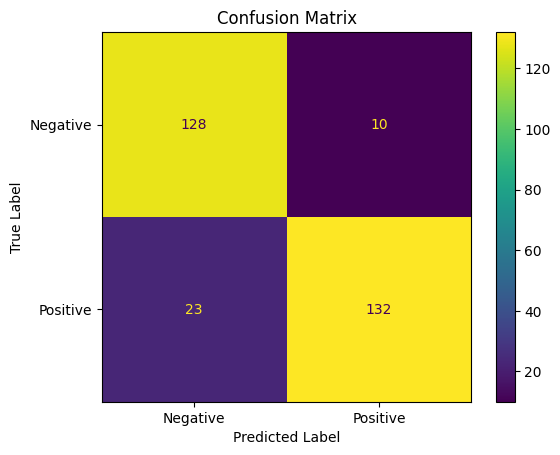

In [ ]:

def build_combined_model(input_shape):
    # First Model
    input1 = Input(shape=input_shape)
    model1 = Sequential()
    model1.add(Conv1D(64, kernel_size=50, activation='relu', input_shape=input_shape))
    model1.add(MaxPooling1D(pool_size=2))
    model1.add(Conv1D(128, kernel_size=20, activation='relu'))
    model1.add(MaxPooling1D(pool_size=2))
    model1.add(Conv1D(256, kernel_size=4, activation='relu'))
    model1.add(GlobalMaxPooling1D())
    model1.add(Dense(128, activation='relu'))
    model1.add(Dropout(0.2))
    output1 = model1(input1)

    # Second Model
    input2 = Input(shape=input_shape)
    model2 = Sequential()
    model2.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=input_shape))
    model2.add(MaxPooling1D(pool_size=4))
    model2.add(Conv1D(filters=64, kernel_size=8, activation='relu'))
    model2.add(Dropout(rate=0.2))
    model2.add(Conv1D(filters=128, kernel_size=10, activation='relu'))
    model2.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
    model2.add(GlobalMaxPooling1D())
    model2.add(Dense(128, activation='relu'))
    model1.add(Dropout(0.2))
    output2 = model2(input2)

    merged = Concatenate()([output1, output2])
    merged = Dense(64, activation='relu')(merged)
    merged = Dense(1, activation='sigmoid')(merged)
    combined_model = Model(inputs=[input1, input2], outputs=merged)

    return combined_model


model = build_combined_model((WS_B, 1))
model.summary()
model.compile(optimizer=AdamW(), loss='binary_crossentropy', metrics=['accuracy'])
#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit([X_train, X_train], [y_train, y_train], epochs=40, batch_size=32, validation_data=([X_val, X_val], [y_val, y_val]), verbose=1, callbacks=[early_stopping])
loss, accuracy = model.evaluate([X_test, X_test], [y_test, y_test])

# Predict labels for test data
y_pred = model.predict([X_test, X_test])
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)
#plot_f1_score_threshold(y_test, y_pred)

# Probably Improved Best Combined

/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "functional_82"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ force_input         │ (None, 800, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 64)        │    339,072 │ force_input[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 64)        │    119,488 │ force_input[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 128)       │          0 │ sequential_7[0][… │
│ (Concatenate)       │                   │            │ sequential_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 128)       │          0 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 64)        │      8,256 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 1)         │         65 │ dense_17[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 466,881 (1.78 MB)

 Trainable params: 466,881 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 237ms/step - accuracy: 0.5104 - loss: 0.6950 - val_accuracy: 0.5324 - val_loss: 0.6743
Epoch 2/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5688 - loss: 0.6943 - val_accuracy: 0.6621 - val_loss: 0.6052
Epoch 3/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6243 - loss: 0.6250 - val_accuracy: 0.6655 - val_loss: 0.5896
Epoch 4/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6879 - loss: 0.5847 - val_accuracy: 0.7201 - val_loss: 0.5128
Epoch 5/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7315 - loss: 0.5088 - val_accuracy: 0.7201 - val_loss: 0.4746
Epoch 6/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7378 - loss: 0.4862 - val_accuracy: 0.8259 - val_loss: 0.3767
Epoch 7/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8236 - loss: 0.3674 - val_accuracy: 0.8567 - val_loss: 0.3444
Epoch 8/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8886 - loss: 0.3172 - val_accuracy: 0.7645 - val_l

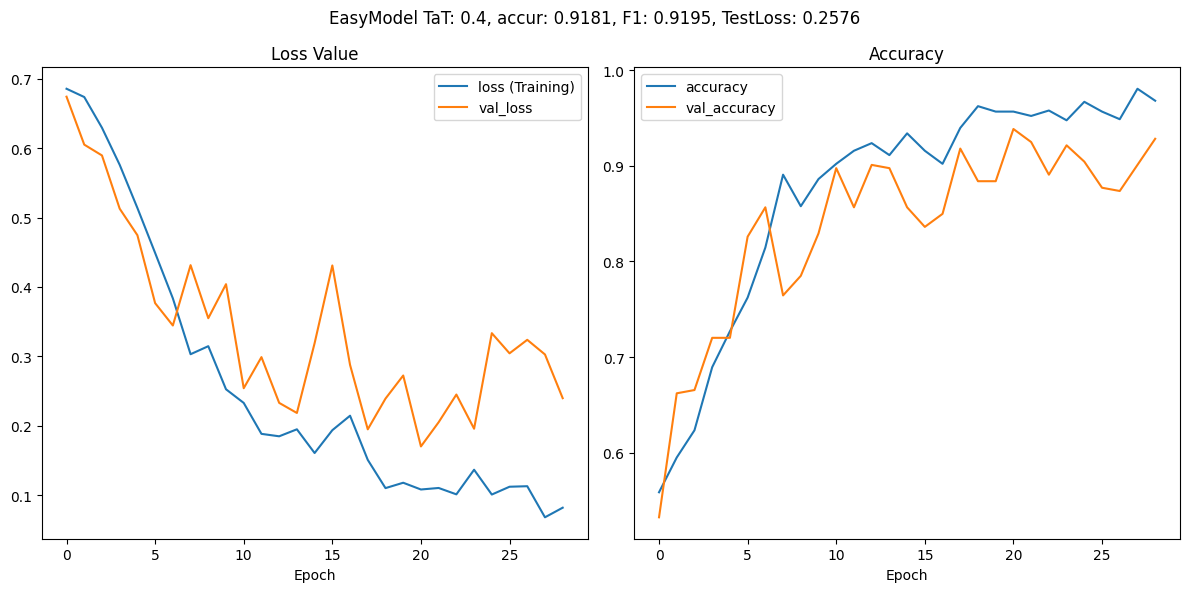

Train loss: 0.08180376887321472
Test val_loss: 0.23967882990837097
Train accuracy: 0.9681456089019775
Accuracy Score: 0.9180887372013652
F1 Score: 0.9194630872483222
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.96      0.92       138
         1.0       0.96      0.88      0.92       155

    accuracy                           0.92       293
   macro avg       0.92      0.92      0.92       293
weighted avg       0.92      0.92      0.92       293



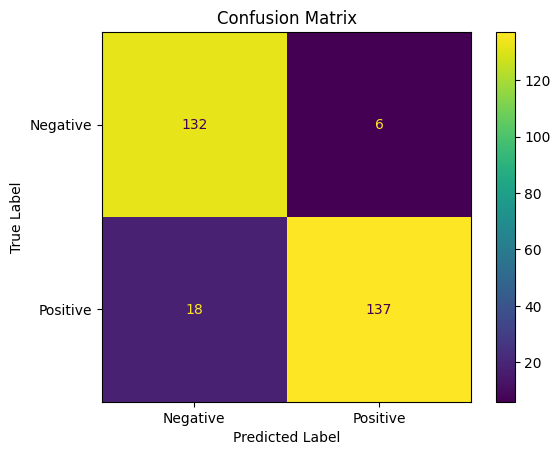

In [ ]:

def build_combined_model(input_shape):
    force_input = Input(shape=input_shape, name='force_input')
    Fbranch1 = Sequential()
    Fbranch1.add(Conv1D(64, kernel_size=40, strides=8, activation='relu', input_shape=input_shape))
    Fbranch1.add(MaxPooling1D(pool_size=2))
    Fbranch1.add(Conv1D(128, kernel_size=20, strides=2, activation='relu'))
    Fbranch1.add(MaxPooling1D(pool_size=2))
    Fbranch1.add(Conv1D(256, kernel_size=4, activation='relu'))
    Fbranch1.add(GlobalMaxPooling1D())
    Fbranch1.add(Dense(128, activation='relu'))
    Fbranch1.add(Dropout(0.2))
    Fbranch1.add(Dense(64, activation='relu'))
    outF1 = Fbranch1(force_input)

    Fbranch2 = Sequential()
    Fbranch2.add(Conv1D(128, kernel_size=2,  activation='relu', input_shape=input_shape))
    Fbranch2.add(MaxPooling1D(pool_size=2))
    Fbranch2.add(Conv1D(64, kernel_size=8, strides=2, activation='relu'))
    Fbranch2.add(MaxPooling1D(pool_size=2))
    Fbranch2.add(Conv1D(128, kernel_size=4, activation='relu'))
    Fbranch2.add(Conv1D(64, kernel_size=2, activation='relu'))
    Fbranch2.add(GlobalMaxPooling1D())
    Fbranch2.add(Dropout(0.1))
    Fbranch2.add(Dense(64, activation='relu'))
    outF2 = Fbranch2(force_input)
    
    merged = concatenate([outF1, outF2])
    merged = Dropout(0.1)(merged)
    merged = Dense(64, activation='relu')(merged)
    merged = Dense(1, activation='sigmoid')(merged)
    combined_model = Model(inputs=[force_input, force_input], outputs=merged)

    return combined_model


model = build_combined_model((WS_B, 1))
model.summary()
model.compile(optimizer=AdamW(), loss='binary_crossentropy', metrics=['accuracy'])

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit([X_train, X_train], [y_train, y_train], epochs=60, batch_size=32, validation_data=([X_val, X_val], [y_val, y_val]), verbose=1, callbacks=[early_stopping])
loss, accuracy = model.evaluate([X_test, X_test], [y_test, y_test])

# Predict labels for test data
y_pred = model.predict([X_test, X_test])
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)
#plot_f1_score_threshold(y_test, y_pred)